In [ ]:
import random
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [ ]:
# Handwriting, from Homework 6
def extract_data(filename):
  data = []
  with open(filename) as f:
    for line in f:
      cols = line.split()
      if len(cols) < 256: # Bad data
        continue
      digit = int(float(cols[0]))
      # However, we need to set 1 to +1 and others as -1
      data.append((1 if digit is 1 else -1, np.reshape([float(pixel) for pixel in cols[1:]], (-1, 16))))
  return data

trainData = extract_data('/content/drive/MyDrive/handwriting/ZipDigits.train')
testData = extract_data('/content/drive/MyDrive/handwriting/ZipDigits.test')
allData = trainData + testData

In [ ]:
# Features from homework 6
# Nomalized by divided 16 * 16 = 256
# left right 
def symmetry(image):
  res = 0.0
        
  for i in range(8):
      for j in range(16):
          res += abs(image[i][j]-image[15-i][j])
  return res / 256

def intensity(image):
  return np.sum(image) / 256

intensityData = [(y, intensity(x)) for (y, x) in allData]
symmetryData = [(y, symmetry(x)) for (y, x) in allData]

# Make max to 1 and min to -1
def normalize(data, x_max_target=1.0, x_min_target=-1.0):
  x = [x for (y, x) in data]
  x_max = max(x)
  x_min = min(x)
  # scale is to make it the same range(clac distance) as the target
  x_scale = float(x_max_target - x_min_target) / float(x_max - x_min)
  # shift is to align the target, by calculate mid points and align them
  # min + (max - min) / 2 = min + max / 2 - min / 2 = (min + max) / 2
  x_shift = float(x_min_target + x_max_target) / 2 - float(x_max + x_min) / 2 
  
  sc = lambda x1: (x1 + x_shift) * x_scale

  normalized_data = [(y, sc(x)) for (y, x) in data]
      
  return normalized_data

normalizedIntensityData = normalize(intensityData)
normalizedSymmetryData = normalize(symmetryData)

In [ ]:
# Random 300 data
def randomTrainTestData(*features,train_num=300):
  data = []
  for i in range(len(features[0])):
    ls = []
    for j in range(len(features)):
      ls.append(features[j][i][1])
    data.append((features[j][i][0], tuple(ls)))
  
  random.shuffle(data)
  train = data[:train_num]
  test = data[train_num:]

  return train, test

train, test = randomTrainTestData(normalizedIntensityData, normalizedSymmetryData)

In [ ]:
def regularized_linear_regression(data, lamb):
  Z = [z for (y, z) in data]
  Y = [y for (y, z) in data]
  Y = np.transpose(Y)
  dimension = len(Z[0])
  
  
  I = np.identity(dimension)
  ZT = np.transpose(Z)
  ZTZ = np.dot(ZT, Z)
  REG = np.dot(lamb, I)
  ZTZ_REG = ZTZ + REG
  ZTZ_REG_inv = np.linalg.inv(ZTZ_REG)
  ZTZ_REG_inv_ZT = np.dot(ZTZ_REG_inv, ZT)
  w_reg = np.dot(ZTZ_REG_inv_ZT, Y)
    
  
  return w_reg

In [ ]:
# From homework 6
def plot_features(*data):    
  fig, axs = plt.subplots(1)
  is_1 = []
  not_1 = []
  for d in data:
    for y, x in d:
      if y == 1:
        is_1.append(x)
      elif y == -1:
        not_1.append(x)
  

  axs.scatter(*zip(*is_1), color="blue", marker="o", label="is 1")
  axs.scatter(*zip(*not_1), color="red", marker="x", label="not 1")

  axs.set_xlabel("Intensity")
  axs.set_ylabel("Symmetry(horizonal)")
  return fig, axs

In [ ]:
# Legendre polynomial
def LP(n, x):
  cache = [None] * (n + 1)
  return LP_rec(n, x, cache)

def LP_rec(n, x, cache): 
  if n == 0:
    return 1 # L0 = 1
  elif n == 1:
    return x # L1 = x
  elif n < len(cache) - 1 and cache[n] is not None:
    return cache[n]
  else:
    res = (((2 * n) - 1) * x * LP_rec(n-1, x, cache) - (n-1) * LP_rec(n-2, x, cache)) / float(n)
    cache[n] = res
    return res

coeffGenCache = [None] * 100
def coeffGen(order):
  if order < len(coeffGenCache) and coeffGenCache[order] is not None:
    return coeffGenCache[order]
  l = np.arange(0, order+1, 1)
  ls = [(order-i,i) for i in l]
  coeffGenCache[order] = ls
  return ls

def legendreTransform(order, x1, x2):
  order_list = []
  for i in range(order + 1):
    order_list += coeffGen(i)
  
  values = [LP(j, x1) * LP(k, x2) for (j, k) in order_list]

  return values

In [ ]:
# Line range, just make it longer than the max x
x1_params = np.linspace(-1,1.2) # Intensity range
x2_params = np.linspace(-1,1.2)  # Symmetry range
levels = [0] # For contour, we only need first one
x1, x2 = np.meshgrid(x1_params,x2_params)
order = 8
transformed_train = [(y, legendreTransform(order, x[0], x[1])) for (y, x) in train]
transformed_test = [(y, legendreTransform(order, x[0], x[1])) for (y, x) in test]

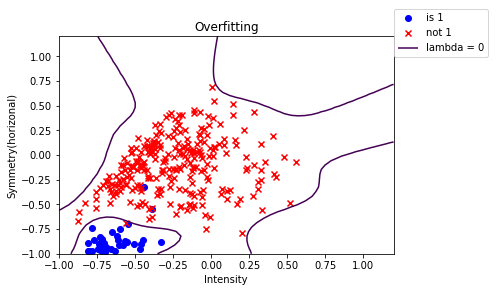

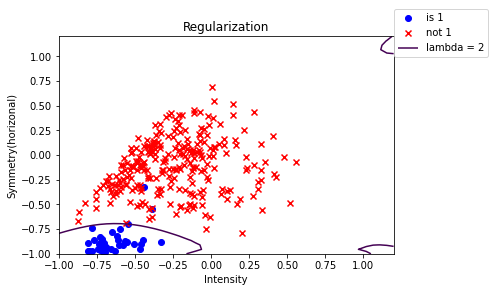

In [ ]:
def draw_seps(wlin, title, lamb, *data):
  fig1, axs1 = plot_features(*data)
  transformed = [legendreTransform(order, x1, x2) for (x1, x2) in zip(x1, x2)]
  Z = [sum([coef * feature for coef, feature in zip(wlin, x)]) for x in transformed]
  cs1 = axs1.contour(x1, x2, Z, levels = levels)
  cs1.collections[0].set_label("lambda = {}".format(lamb)) # set first level line
  axs1.set_title(title)

  fig1.legend(bbox_to_anchor=(0.9, 1), loc='upper left')

# Q2
trainWlin = regularized_linear_regression(transformed_train, 0)
draw_seps(trainWlin, "Overfitting", 0, train)
# Q3
trainWlin = regularized_linear_regression(transformed_train, 2)
draw_seps(trainWlin, "Regularization", 2, train)

In [ ]:
def cross_validation(data, lamb):
  Z = [z for (y, z) in data]
  Y = [y for (y, z) in data]
  Y = np.transpose(Y)
  dimension = len(Z[0])
  
  I = np.identity(dimension)
  ZT = np.transpose(Z)
  ZTZ = np.dot(ZT, Z)
  REG = np.dot(lamb, I)
  ZTZ_REG = ZTZ + REG
  ZTZ_REG_inv = np.linalg.inv(ZTZ_REG)
  Z_ZTZ_REG_inv = np.dot(Z, ZTZ_REG_inv)
  H = np.dot(Z_ZTZ_REG_inv, ZT)
  Y_hat = np.dot(H, Y)

  E_cv = 0.0
  N = len(data)
  for n in range(N):
    E_cv += ((float(Y_hat[n] - Y[n]) / (1 - H[n][n]))**2) / N
    
  return E_cv

# We need Regression Error!
def calc_acc(weights, data):
  correct = 0
  for y, x in data:
      correct += (y - np.dot(weights, x)) **2

  return float(correct) / len(data)

def run_cv():
  E_cv_list=[]
  E_test_list=[]
  lambda_list = np.arange(0, 2, 0.01)
  min_lambda = 9999.99
  min_E_cv = 9999.99
  for lamb in lambda_list:
    wlin = regularized_linear_regression(transformed_train, lamb)   
    E_cv = cross_validation(transformed_train, lamb)
    E_test = calc_acc(wlin, transformed_test)
    if min_E_cv > E_cv:
      min_lambda = lamb
      min_E_cv = E_cv
    E_cv_list.append(E_cv)
    E_test_list.append(E_test)
  
  return E_cv_list, E_test_list, lambda_list, round(min_lambda, 2)

E_cv_list, E_test_list, lambda_list, min_lambda = run_cv()

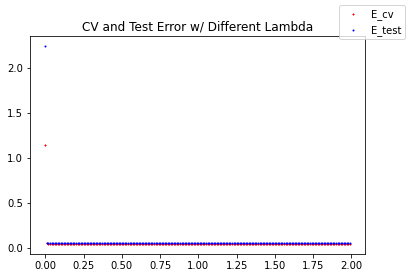

In [ ]:
# Q4
def draw_cv(E_cv_list, E_test_list, lambda_list):
  fig, axs = plt.subplots()
  axs.scatter(lambda_list, E_cv_list, color="red", marker="x", s=1, label="E_cv")
  axs.scatter(lambda_list, E_test_list, color="blue", marker="o", s=1,label="E_test")
  axs.set_title("CV and Test Error w/ Different Lambda")

  fig.legend()

draw_cv(E_cv_list, E_test_list, lambda_list)

0.36


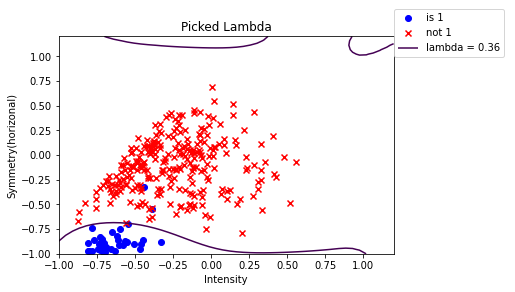

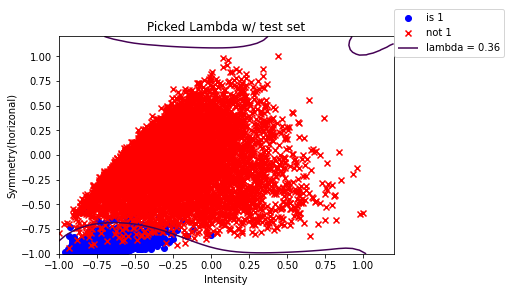

In [ ]:
#Q5
print(min_lambda)
trainWlin = regularized_linear_regression(transformed_train, min_lambda)
draw_seps(trainWlin, "Picked Lambda", min_lambda, train)
draw_seps(trainWlin, "Picked Lambda w/ test set", min_lambda, train, test)

In [ ]:
# Q6
E_test = calc_acc(trainWlin, transformed_test)
len_test = len(transformed_test)
print("E_test: {}, num: {}".format(E_test, len_test))

E_test: 0.04102440401965158, num: 8998
